<a href="https://colab.research.google.com/github/AlirezaAK2000/Digit-Recognition/blob/master/AI_First_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')


In [4]:
train_images_file = open('drive/MyDrive/colab samples/train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('drive/MyDrive/colab samples/train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)


8

In [5]:
train_set = []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    train_set.append((image, label))



In [6]:
# Reading The Test Set
test_images_file = open('drive/MyDrive/colab samples/t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('drive/MyDrive/colab samples/t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_set = []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))


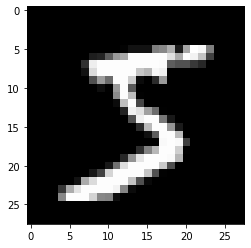

In [7]:
# Plotting an image
show_image(train_set[0][0])
plt.show()

**Vectorizing**

stack all samples in one matrix

In [8]:
train_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in train_set])))
train_set_x_v.shape
test_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in test_set])))
test_set_x_v.shape

(784, 10000)

In [9]:
train_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in train_set])))
train_set_y_v.shape
test_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in test_set])))
test_set_y_v.shape

(10, 10000)

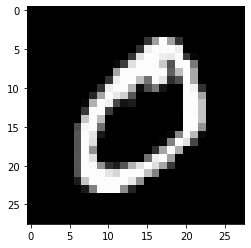

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
show_image(np.transpose(train_set_x_v[:,1]))
plt.show()
train_set_y_v[1]

In [11]:
def sigmoid(A):
  return 1/(1+np.exp(-1 * A))
def sigmoid_deriv(A):
  sig = sigmoid(A)
  return sig * (1 - sig)
def softmax(A):
  e = np.exp(A)
  return e / np.sum(e)
def relu(A):
  return np.maximum(A , 0)
def relu_deriv(A):
  return (A > 0).astype(int)
def tanh(A):
  return np.tanh(A)
def tanh_deriv(A):
  return 1 - tanh(A) ** 2
def leaky_relu(A,alpha=0.01):
  return np.where(A > 0, A, A * alpha)     
def leaky_relu_deriv(A, alpha=0.01):
  dx = np.ones_like(A)
  dx[A < 0] = alpha
  return dx                     

# Model

define your model here :

for the first element just shape of the input

```
(dataset_size , None)
```

for hidden layers define neurons , activation function and derivative

```
(neurons , activation , activation_deriv)
```


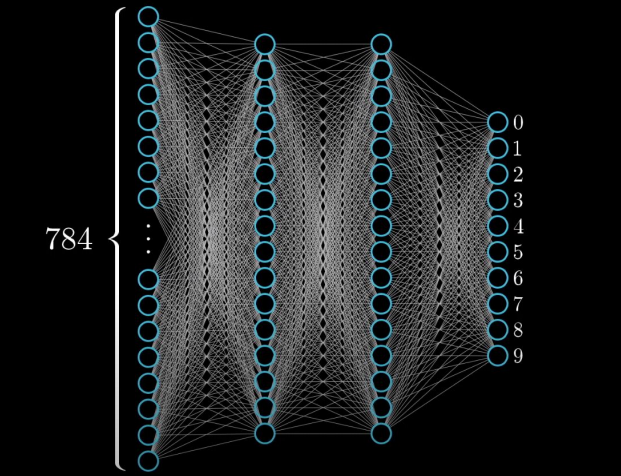


In [12]:
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
model

[(784, None),
 (16, <function __main__.relu>, <function __main__.relu_deriv>),
 (16, <function __main__.relu>, <function __main__.relu_deriv>),
 (10, <function __main__.sigmoid>, <function __main__.sigmoid_deriv>)]

In [13]:
np.random.seed(2)
def get_dimensions(model):
  dimensions = [(model[i+1][0], model[i][0]) for i in range(len(model)-1)]
  return dimensions
dimensions = get_dimensions(model)

# Weight Initialization 

using proper technique to initialize weights , helps model for faster and better learning.
here we are using **HE** initializing which is good for models with relu activation functions.
refrence : [He et al., 2015](https://arxiv.org/abs/1512.03385)

In [27]:
def initializer(shape ):
  w = np.random.randn(shape[0],shape[1]) * np.sqrt(2./shape[1])
  # b = np.random.randn(shape[0] , 1) * np.sqrt(2./shape[1])
  b = np.zeros((shape[0] , 1))

  return (w , b)
def V_initializer(shape ):
  v_w = np.zeros(shape)
  v_b = np.zeros((shape[0] , 1))

  return (v_w , v_b)

In [28]:
def initialize(model,use_momentum = False):
  W = []
  B = []
  for shape in dimensions:
    w , b  = initializer(shape)
    assert(w.shape == shape)
    assert(b.shape == (shape[0] , 1))
    W.append(w)
    B.append(b)
  if use_momentum:
    V = {'dW':[],'dB':[]}
    for shape in dimensions:
      v_w , v_b  = V_initializer(shape)
      V['dW'].append(v_w)
      V['dB'].append(v_b)
    return W , B , V

  return W , B , None
W , B , _ = initialize(model)

In [16]:
def mse_cost(y , y_prim):
  return np.sum((y_prim-y)**2)/y.shape[1]

In [17]:
def forward_propagation(X , W , B,model):
  layers_num = len(W)
  A = [X]
  Z = []
  for i in range(layers_num):
    # assert(W[i].shape[1] == X.shape[0])
    z = W[i] @ A[i] + B[i]
    a = model[i + 1][1](z)
    A.append(a)
    Z.append(z)
    # print(z.shape)
  return {
      'A':A,
      'Z':Z
  }

In [18]:
# print(train_set_x_v.shape)
cache = forward_propagation(train_set_x_v , W , B,model)
assert(train_set_y_v.shape == cache['A'][-1].shape)
for i in cache['A']:
  print(i.shape)

(784, 60000)
(16, 60000)
(16, 60000)
(10, 60000)


In [19]:
mse_cost(train_set_y_v,cache['A'][-1])
cache['Z'][0].shape

(16, 60000)

In [119]:
def backward_propagation(W , B , cache, Y , model):
  A , Z = cache['A'] ,cache['Z']
  # print(Z)
  dW , dB= [] , []
  layers_num = len(W)
  tmp = (2 * (A[-1] - Y)) * model[-1][2](Z[-1])
  db = tmp  @ np.ones((A[-1].shape[1],1))
  dw = tmp  @ np.transpose(A[-2])
  dA = [np.transpose(W[-1]) @ tmp]
  assert(dw.shape == W[-1].shape)
  assert(db.shape == B[-1].shape)
  dW.append(dw)
  dB.append(db)
  for i in reversed(range(layers_num - 1)):
    tmp = dA[0] * model[i+1][2](Z[i])
    db = tmp @ np.ones((tmp.shape[1],1))
    dw = tmp @ np.transpose(A[i])
    da = np.transpose(W[i]) @ tmp
    dA.insert(0,da)
    dW.insert(0,dw)
    dB.insert(0,db)
    assert(dw.shape == W[i].shape)
    assert(db.shape == B[i].shape)

  return {
      'dW':dW,
      'dB':dB
  }
def update_params(W , B , gradients ,a , use_momentum=False,V=None , beta=0.9):
    if not use_momentum:
      for k in range(len(W)):
        W[k] = W[k] - a * gradients['dW'][k]
        B[k] = B[k] - a * gradients['dB'][k]
    else:
      for k in range(len(W)):

        V['dW'][k] = beta * V['dW'][k] + (1 - beta) * gradients['dW'][k]
        W[k] = W[k] - a * V['dW'][k]
        V['dB'][k] = beta * V['dB'][k] + (1 - beta) * gradients['dB'][k]
        B[k] = B[k] - a * V['dB'][k]
def predict(W, B , X , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  return np.where(Y_prim.reshape(Y_prim.shape[1]) == 1)[0][0]



In [21]:
a = backward_propagation(W,B, cache,train_set_y_v , model)

In [92]:
from collections import defaultdict
def test(W, B , X ,Y , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  result = defaultdict(lambda : 0,dict(zip(*(np.unique((Y_prim == Y).all(0) , return_counts=True)))))
  return result[True] / (result[True] + result[False]) * 100


def main_model(model , X , Y ,X_test , Y_test , epoch=200 , batch_size=20 , a=1, use_momentum = False, beta=0.9):
  costs , test_accuracies , train_accuracies = [] , [] , []
  num_iteration = X.shape[1]//batch_size
  W , B , V = initialize(model,use_momentum)
  for i in range(epoch):
    cost = None
    for j in range(num_iteration):
      batch_x = X[:,j*batch_size:(j+1)*batch_size]
      batch_y = Y[:,j*batch_size:(j+1)*batch_size]
      cache = forward_propagation(batch_x , W,B,model)
      cost = mse_cost(batch_y , cache['A'][-1])
      gradients = backward_propagation(W , B , cache , batch_y , model)
      update_params(W , B , gradients , a , use_momentum , V,beta)
    # if i % 10 == 0:
    train_accuracy = test(W , B , X , Y , model)
    test_accuracy = test(W , B , X_test , Y_test , model)
    print(f'*** epoch : {i} ======> cost : {cost} , train accuracy : {train_accuracy} , test accuracy : {test_accuracy}')
    costs.append(cost)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

  train_accuracy = test(W , B , X , Y , model)
  test_accuracy = test(W , B , X_test , Y_test , model)
  print('__________________________________________________')
  print(f"train accuracy: {train_accuracy}")
  print(f"test accuracy: {test_accuracy}")  
  return costs , test_accuracies , train_accuracies , W , B



In [62]:
def plot_result(info): 
  plt.plot([i for i in range(1,len(info[0])+1)] , info[0] , label='cost')
  plt.legend(loc="upper right", frameon=False)
  plt.show()
  plt.plot([i for i in range(1,len(info[1])+1)] , info[1] , label='test accuracy')
  plt.plot([i for i in range(1,len(info[2])+1)] , info[2] , label='train accuracy')
  plt.legend(loc="upper left", frameon=False)
  plt.show()

def describe_model(model):
  print('\n'.join([str({'activation units':model[i][0],'activation function':model[i][1].__name__ ,'parameters': model[i][0]*model[i-1][0] }) if model[i][1] else f'input layer : {model[i][0]}' for i in range(len(model))]))


input layer : 784
{'activation units': 16, 'activation function': 'relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.012464017063341453 , train accuracy : 84.47166666666666 , test accuracy : 84.53
*** epoch : 1 ======> cost : 0.011244979724283096 , train accuracy : 87.86833333333334 , test accuracy : 87.45
*** epoch : 2 ======> cost : 0.030925326879676945 , train accuracy : 90.75333333333333 , test accuracy : 90.25
*** epoch : 3 ======> cost : 0.02558242110737572 , train accuracy : 91.7 , test accuracy : 91.10000000000001
*** epoch : 4 ======> cost : 0.006270564116642804 , train accuracy : 91.97166666666666 , test accuracy : 91.09
*** epoch : 5 ======> cost : 0.00998934931506562 , train accuracy : 92.29 , test accuracy : 91.46
*** epoch : 6 ======> cost : 0.009511534633505618 , train accuracy : 92.41666666666667 , test accurac

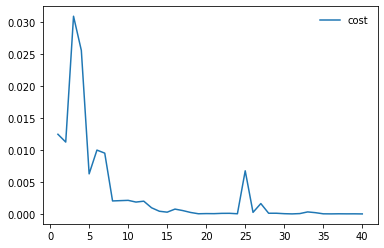

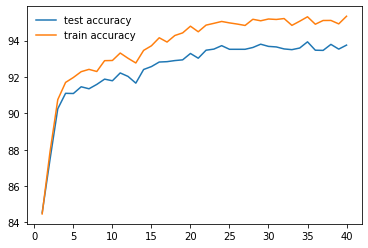

In [95]:
# using relu and momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.8)
plot_result(info)

No overfit !!!

input layer : 784
{'activation units': 16, 'activation function': 'relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.004772535336487452 , train accuracy : 87.17333333333333 , test accuracy : 86.87
*** epoch : 1 ======> cost : 0.002099491378567895 , train accuracy : 88.23666666666666 , test accuracy : 87.77000000000001
*** epoch : 2 ======> cost : 0.01776584380903623 , train accuracy : 91.225 , test accuracy : 90.85
*** epoch : 3 ======> cost : 0.004303054297878249 , train accuracy : 91.16333333333333 , test accuracy : 90.82000000000001
*** epoch : 4 ======> cost : 0.013815076220423527 , train accuracy : 92.21666666666667 , test accuracy : 91.45
*** epoch : 5 ======> cost : 0.0011309061730233703 , train accuracy : 92.71833333333333 , test accuracy : 92.12
*** epoch : 6 ======> cost : 0.0038317041709293813 , train accuracy : 93.

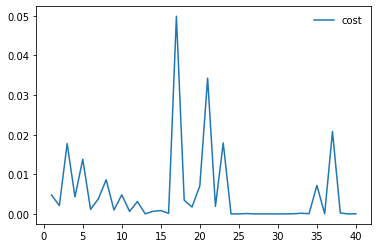

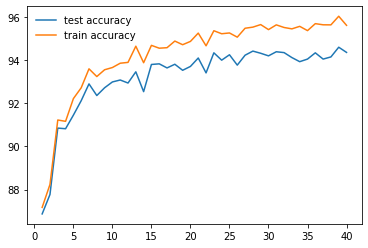

In [54]:
# using relu and without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=False)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.1920954560813138 , train accuracy : 72.41166666666666 , test accuracy : 73.28
*** epoch : 1 ======> cost : 0.05651694152366866 , train accuracy : 85.54666666666667 , test accuracy : 85.75
*** epoch : 2 ======> cost : 0.03896733739679492 , train accuracy : 88.08500000000001 , test accuracy : 87.98
*** epoch : 3 ======> cost : 0.030792505522363334 , train accuracy : 89.46333333333332 , test accuracy : 89.42
*** epoch : 4 ======> cost : 0.02482352245678413 , train accuracy : 90.42999999999999 , test accuracy : 90.28
*** epoch : 5 ======> cost : 0.019899117365473784 , train accuracy : 91.12333333333333 , test accuracy : 90.8
*** epoch : 6 ======> cost : 0.015883872078378644 , train accuracy : 91.67 , test accu

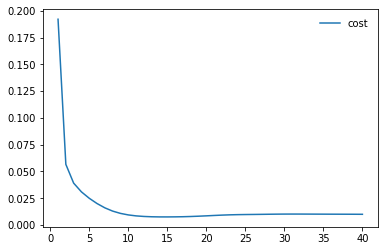

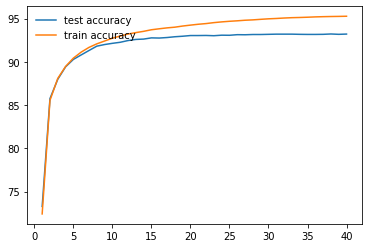

In [91]:
# using sigmoid with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.8,batch_size=128)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.1850458808522426 , train accuracy : 75.80666666666667 , test accuracy : 77.13
*** epoch : 1 ======> cost : 0.05565115426086009 , train accuracy : 85.45833333333334 , test accuracy : 85.9
*** epoch : 2 ======> cost : 0.04531873789506347 , train accuracy : 87.78333333333333 , test accuracy : 87.9
*** epoch : 3 ======> cost : 0.03897812298591276 , train accuracy : 89.22833333333332 , test accuracy : 88.92999999999999
*** epoch : 4 ======> cost : 0.02546689819606046 , train accuracy : 90.12833333333333 , test accuracy : 89.66
*** epoch : 5 ======> cost : 0.017176795920766322 , train accuracy : 90.84333333333333 , test accuracy : 90.42
*** epoch : 6 ======> cost : 0.0149520025332055 , train accuracy : 91.428333

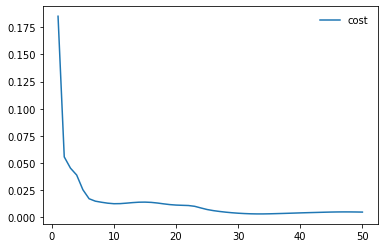

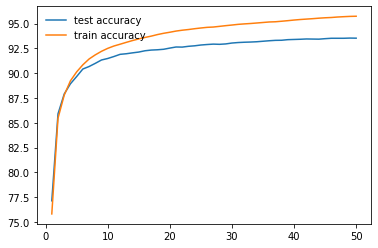

In [40]:
# using sigmoid without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 )
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'tanh', 'parameters': 12544}
{'activation units': 16, 'activation function': 'tanh', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.020647498151506495 , train accuracy : 87.97166666666666 , test accuracy : 88.01
*** epoch : 1 ======> cost : 0.019377516475423878 , train accuracy : 89.62666666666667 , test accuracy : 89.59
*** epoch : 2 ======> cost : 0.0329188229864793 , train accuracy : 90.89500000000001 , test accuracy : 90.74
*** epoch : 3 ======> cost : 0.035754983369084434 , train accuracy : 91.70833333333334 , test accuracy : 91.27
*** epoch : 4 ======> cost : 0.016887011899688168 , train accuracy : 92.02166666666668 , test accuracy : 91.52
*** epoch : 5 ======> cost : 0.00688326095553911 , train accuracy : 91.91333333333334 , test accuracy : 91.4
*** epoch : 6 ======> cost : 0.0019380857041440124 , train accuracy : 92.17166666666667 , 

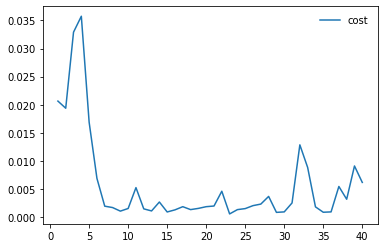

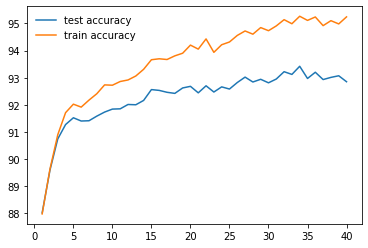

In [48]:
# using tanh with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , tanh ,tanh_deriv ),
    (16 , tanh ,tanh_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40, use_momentum=True , beta=0.85)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'tanh', 'parameters': 12544}
{'activation units': 16, 'activation function': 'tanh', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.01605807514797743 , train accuracy : 88.36833333333334 , test accuracy : 88.42999999999999
*** epoch : 1 ======> cost : 0.009335887848434274 , train accuracy : 90.13166666666666 , test accuracy : 90.14
*** epoch : 2 ======> cost : 0.003555778569937189 , train accuracy : 91.445 , test accuracy : 91.33
*** epoch : 3 ======> cost : 0.0027439294360021597 , train accuracy : 92.11333333333333 , test accuracy : 91.45
*** epoch : 4 ======> cost : 0.0018551476765354686 , train accuracy : 91.88499999999999 , test accuracy : 91.14999999999999
*** epoch : 5 ======> cost : 0.002860538162245133 , train accuracy : 92.84666666666666 , test accuracy : 92.0
*** epoch : 6 ======> cost : 0.0010427151267097372 , train accuracy : 93.

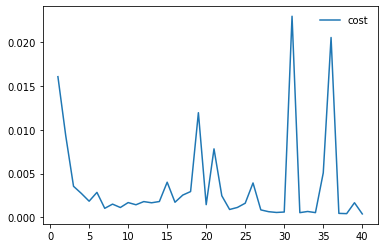

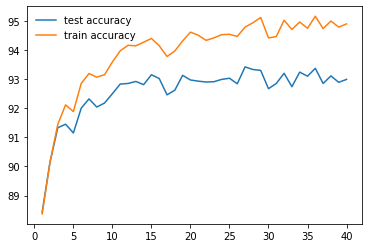

In [43]:
# using tanh without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , tanh ,tanh_deriv ),
    (16 , tanh ,tanh_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40, use_momentum=False )
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.03192254704757949 , train accuracy : 82.57833333333333 , test accuracy : 82.61
*** epoch : 1 ======> cost : 0.02651854537452646 , train accuracy : 85.97833333333334 , test accuracy : 85.95
*** epoch : 2 ======> cost : 0.026918444016538434 , train accuracy : 87.22999999999999 , test accuracy : 86.91
*** epoch : 3 ======> cost : 0.012812772480987469 , train accuracy : 88.41833333333334 , test accuracy : 88.08
*** epoch : 4 ======> cost : 0.03649003722597051 , train accuracy : 87.73333333333333 , test accuracy : 87.21
*** epoch : 5 ======> cost : 0.003758760403413276 , train accuracy : 88.91166666666666 , test accuracy : 88.58
*** epoch : 6 ======> cost : 0.007250319408023046 , train accuracy : 90.22833

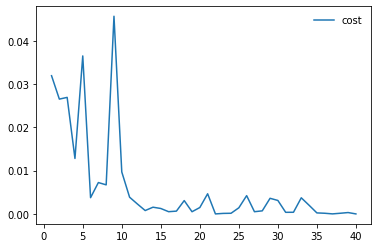

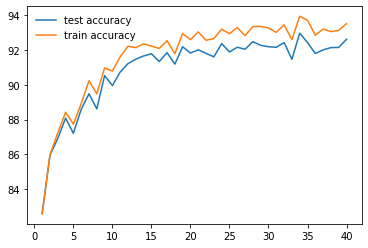

In [44]:
# using leaky relu with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.8)
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.005240038084233003 , train accuracy : 86.11333333333333 , test accuracy : 85.8
*** epoch : 1 ======> cost : 0.0010870158994887788 , train accuracy : 88.68166666666667 , test accuracy : 88.23
*** epoch : 2 ======> cost : 0.00022390708662119917 , train accuracy : 90.89166666666667 , test accuracy : 90.21000000000001
*** epoch : 3 ======> cost : 0.0003909043308723614 , train accuracy : 91.22333333333333 , test accuracy : 90.8
*** epoch : 4 ======> cost : 0.00021672584622738127 , train accuracy : 92.945 , test accuracy : 92.47
*** epoch : 5 ======> cost : 0.0004235451007332908 , train accuracy : 92.58333333333333 , test accuracy : 92.11
*** epoch : 6 ======> cost : 0.0016275269835753312 , train accuracy 

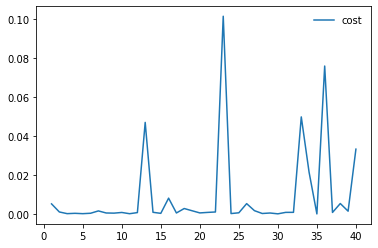

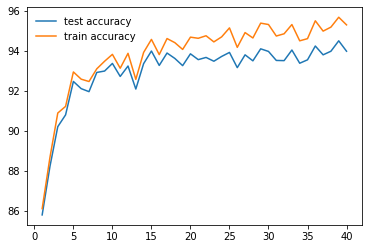

In [45]:
# using leaky relu without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=False)
plot_result(info)

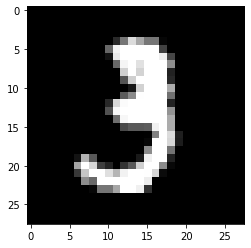

predicted value: 3


In [121]:
show_image(np.transpose(train_set_x_v[:,10]))
pic = train_set_x_v[:,10].reshape((1,-1,1))
W , B = info[3], info[4]
plt.show()
print(f"predicted value: {predict(W,B,pic, model )}")

